# TEAM NAP: YQuantum Hackathon 2025
### Team Members: Phil Kazembe, Ngaatendwe Manyika, Anopamufaro Manyika

## Tahoe Challenge: Response
- <b> Objective: </b> Create an expandable and customisable quantum-optimized wildfire response model that uses different parameters to assign fire response teams in situations with multiple wildfire outbreaks
- <b> Methodology: </b> To do these we're going to use use 3 different metrics to assess a teams ability to respond to a fire: <b>fire severity , team ability</b> and <b>distance between fire and team</b>. We are going to then use Quantum Optimization to assign teams to different sites based on these factors to optimize allocation of resources.

## Establishing Parameters
### 1. Estimated Fire Severity: Simply calculated from 3 different parameters;
- Fire Intensity (qualitative ranking from 'low' to 'mid' to 'high')
- Fire Size (acres)
- Spread Risk (rated from 0 - 1)

In [117]:
import numpy as np # for matrix/vector functions and simulation
from pyqubo import Binary, Constraint # for QUBO Set Up
import neal # for Quantum Simulation
import matplotlib.pyplot as plt # for visualization of output

# example fire data
fires = {
    'Fire1': {
        'location': (25.03, -73.1),  
        'size_acres': 400,            
        'intensity': 'high',           
        'spread_risk': 0.25             
    }
} 

# fire severity weights equailized for simplicity.
fs_weights = {
    "size_acres": 0.33,     
    "intensity": 0.33,           
    "spread_risk": 0.34
}

# getting a numerical estimate of severity based on weights of different factors (from 0-1)
def demo_calculate_severity(fire):
    sev = 0

    for key in fs_weights:
        if (fire[key]):
            if key == 'size_acres':
                sev += fs_weights[key] * fire[key] / 1000 # just dividing by 1000 for testing purposes 
            elif key == 'intensity': 
                sev += fs_weights[key]*(1 if fire[key] == 'high' else 0.5) # simple intensity metric 1 if high 0.5 in all other cases
            else:
                sev += fs_weights[key]*fire[key] # simple weighting metric for other variables can be adjusted after deeper analysis

    return sev

# printing the output of the severity function
print(f"Fire1 has an estimated severity of {demo_calculate_severity(fires['Fire1'])}")

Fire1 has an estimated severity of 0.547


### 2. Estimated Team Ability: calculated from 2 parameters
- Resources Available for a team (simply ranked from 1 - 4, where a small fire response team would have a rank of 1 while a large federal wild fire response team would have a rank of 3-4)
- Ratio of Active Personnel to Total Personnel

In [118]:
# defining a new team
teams = {
    'Team1' : {
        'location' : (35.07, -123.20),
        'active_personnel' : 25,
        'total_personnel': 40,
        'resources' : 3,
    }
}

# parameter weights initially equalised
t_weights = {
    'personnel' : 0.5,
    'resources' : 0.5,
}

# basic test model to calculate ability of a team to respond to fires
def demo_calculate_ability(team):
    abty = 0; # initializing ability to 0

    for key in t_weights:
        if key == 'personnel':
            abty += t_weights[key] * (team['active_personnel'] / team['total_personnel'])
        else:
            abty += t_weights[key] * team['resources']/3

    return abty

# printing the output of the test model.
print(f"Team1 has an estimated ability of {demo_calculate_ability(teams['Team1'])}")


Team1 has an estimated ability of 0.8125


### 3. Distance Between Team and Fire (km)

In [119]:
#Calculating distance between team and fire
demo_distance = np.linalg.norm(
            np.array(teams['Team1']['location']) - 
            np.array(fires['Fire1']['location'])
        )

print(f'Distance between Team1 and Fire1 is {demo_distance} km.')


Distance between Team1 and Fire1 is 51.09610161254967 km.


## Quantum Optimization
### 1. Generate Synthetic Data to test our model:
   - 10 teams wit random location/ability
   - 20 fires with random location/severities
   - Getting a matrix with the distances between each team and each fire

In [120]:
"""Generating Sample Teams & Fires"""
# Generating 10 teams with varying capabilities
teams = []
team_names = []

for i in range(10):
    # Generating random values for selected parameters
    teams.append( {
        f"Team{i+1}":{
        'location' : (np.random.uniform(10,40), np.random.uniform(-150,-100)),
        'active_personnel' : np.random.randint(5,50),
        'total_personnel' : np.random.randint(10,50),
        'resources' : np.random.randint(1,3) }}
        ) 
    # Generating a list of names for the teams
    team_names.append(f'Team{i+1}')

# Generating 20 fires with varying severities
fires = []
fire_names = []

for j in range(20):
    #Generating random values for seleted parameters
    fires.append( {
        f"Fire{j+1}":{
        'location' : (np.random.uniform(10,40), np.random.uniform(-150,-100)),
        'size_acres' : np.random.randint(50,5000),
        'intensity' : np.random.choice(['low','medium','high']),
        'spread_risk' : np.random.uniform(0.1,1.0) }}
        ) 
    #Generating a list of names for the fires
    fire_names.append(f'Fire{j+1}')
    

         
# Getting the distance matrx
distance_matrix = {
        (i, j): np.linalg.norm(
            np.array(teams[i][team_names[i]]['location']) - 
            np.array(fires[j][fire_names[j]]['location'])
        )
        for i in range(len(team_names))
        for j in range(len(fire_names))
}

### 2. QUBO Formulation
- Binary Variable: x[i,j] = Team i assigned to Fire j.

In [121]:
"""Setting up QUBO Problem"""
# Create index-based binary variables
x = {(i, j): Binary(f"x_{i}_{j}") 
     for i in range(len(team_names)) 
     for j in range(len(fire_names))}

- Cost Function: We're aiming to minimize the weighted sum of:
    - Distance (weighted at 7.0 because distance is arguably the most improtant factor in determine wethere a team can quickly respond to a fire)
    - Fire Severity (weighted at 1.0)
    - Team Ability (weighted at 2.0)

In [122]:
# Getting severity and ability scores
ability_scores = {i: demo_calculate_ability(teams[i][team_names[i]]) for i in range(len(team_names))}
severity_scores = {j: demo_calculate_severity(fires[j][fire_names[j]]) for j in range(len(fire_names))}

# Estimated Weighting of the Scores
distance_weight = 7.0
severity_weight = 1.0
ability_weight = 2.0

# Creating a cost function for minimization
H = sum(
    (distance_weight * distance_matrix[(i, j)]) * (severity_weight * severity_scores[j]) / (ability_weight * ability_scores[i]) * x[(i, j)]
    for i in range(len(team_names)) for j in range(len(fire_names))
    )

- Constraints are set up such that:
    - Every fire must have at least one team allocated.
    - We are trying to maximise team allocation to avoid under-utilisation of resources

In [123]:
# Establishing Constraints for QUBO function
# Ensuring every fire has an assigned team
fire_constraints = sum(
  (1 - sum(x[(i, j)] for i in range(len(team_names))))**2 for j in range(len(fire_names))
)

# Ensuring every team is assigned to atleast one fire to maximize utilization of man power
team_constraints = sum(
    (1 - sum(x[(i, j)] for j in range(len(fire_names))))**2
    for i in range(len(team_names))
)
    

# Final Hamiltonian with fixed indentation
H += 100 * fire_constraints + 5 * team_constraints # heavier multiplier for fire constraints because all fires must be covered


### 3. Solving with Simulated Annealing

In [124]:
"""Quantum Annealing Optimization"""
model = H.compile() # compiling
qubo, offset = model.to_qubo() # solving as a QUBO problem
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(qubo, num_reads = 100)

# processing the results to identify best solution
best_solution = sampleset.first.sample
assignments = [var for var, val in best_solution.items() if val == 1]

### 4. Visualisation of Output
- Strings detailing how teams have been allocated to fire
- A plot showing the position of teams and fires in the x-Y plane:
    - Teams in blue
    - Fires in red
    - Lines from Team to fire, indicating which team has been allocated to which fire

Ideal Team Assignments:
Team0 → Fire1 (Distance: 1.11 km, Severity: 0.67)
Team0 → Fire9 (Distance: 6.58 km, Severity: 0.68)
Team2 → Fire0 (Distance: 19.50 km, Severity: 1.74)
Team2 → Fire10 (Distance: 12.84 km, Severity: 0.62)
Team2 → Fire15 (Distance: 14.52 km, Severity: 0.89)
Team3 → Fire5 (Distance: 9.61 km, Severity: 0.41)
Team4 → Fire8 (Distance: 7.41 km, Severity: 0.73)
Team5 → Fire19 (Distance: 4.91 km, Severity: 0.55)
Team6 → Fire7 (Distance: 3.43 km, Severity: 0.50)
Team7 → Fire18 (Distance: 10.15 km, Severity: 1.75)
Team7 → Fire3 (Distance: 20.78 km, Severity: 1.31)
Team7 → Fire4 (Distance: 1.38 km, Severity: 1.26)
Team7 → Fire6 (Distance: 14.04 km, Severity: 1.54)
Team8 → Fire12 (Distance: 1.50 km, Severity: 0.71)
Team8 → Fire13 (Distance: 6.92 km, Severity: 1.74)
Team8 → Fire14 (Distance: 11.22 km, Severity: 0.39)
Team9 → Fire11 (Distance: 21.24 km, Severity: 1.77)
Team9 → Fire16 (Distance: 12.55 km, Severity: 1.56)
Team9 → Fire17 (Distance: 13.91 km, Severity: 1.81)
Team9 

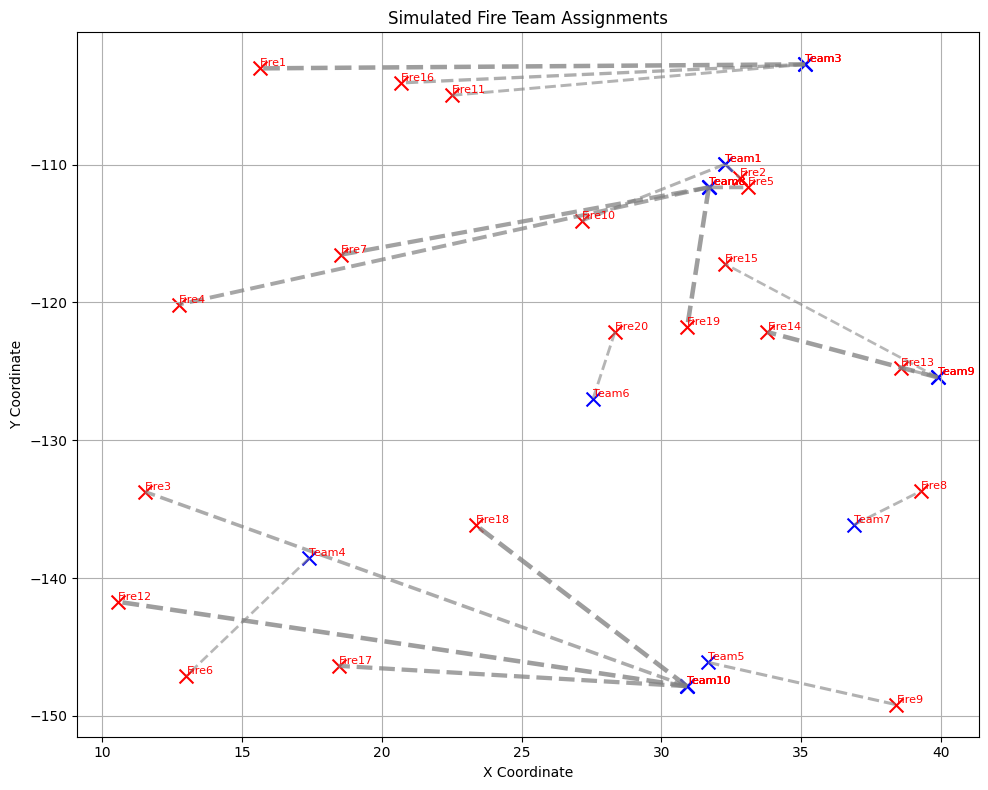

In [125]:

""" Visualization of Output """
# Seting up the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Printing the assignments
print('Ideal Team Assignments:')
for assignment in assignments:
    _, team, fire = assignment.split('_')
    team = int(team) # getting indices of teams
    fire = int(fire) # getting indices of fire

    # Printing the allocations in string form
    dist = distance_matrix[(team, fire)]
    print(f"Team{team} → Fire{fire} (Distance: {dist:.2f} km, Severity: {severity_scores[int(fire)]:.2f})")

    # visualizing the allocations 
    x1, y1 = teams[team][f'Team{team+1}']['location']
    ax.scatter(x1, y1, color='blue', marker='x', s=100)
    ax.text(x1, y1, f'Team{team+1}', fontsize=8, ha='left', va='bottom', color='red')
    
    x2, y2 = fires[fire][f'Fire{fire+1}']['location']
    ax.scatter(x2, y2, color='red', marker='x', s=100)
    ax.text(x2, y2, f'Fire{fire+1}', fontsize=8, ha='left', va='bottom', color='red')

    # setting up lines indicating team allocation
    ax.plot(
        [x1, x2], [y1, y2],
        linestyle='--',
        color='gray',
        linewidth=1.5 + severity_scores[fire],  # thickness shows severity
        alpha=0.5 + 0.3 * (severity_scores[fire] / 2)  # transparency helps layering
    )

# Clean up plot
ax.set_title("Simulated Fire Team Assignments")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.grid(True)
plt.tight_layout()
plt.show()

## Summary of Use Case & Future Steps
- This model is buil primarily using <b>rough estimates</b> and <b>weighting</b> of different variables.
The number and weight of parameters can be adjusted/expanded after conducting historical analysis with real data to improve the total utility of the model.
- By upscaling the quantum hardware used for the system this model can be expanded to accomodate many more variables and do more rigorous analysis.
- Final output can be mapped onto real-world maps for ease of understanding.
- References for code are linked in the write up which can be found in our github repository: https://github.com/Anopamufaro/Team-NAP.
